In [1]:
from utilities import *
import numpy as np
import pandas as pd
from pathlib import Path
from skimage import io
from scipy.stats import zscore
import deepdish as dd
from matplotlib import pyplot as plt
%matplotlib notebook
import seaborn as sns
from matplotlib.patches import Rectangle
# plt.style.use('v_arial')

Master folder with Stytra example data:

In [2]:
sample_data_path = Path("J:\_Shared\stytra\manuscript\datasets")

## Load an experiment and a two-photon stack

Load experiment with the Experiment class:

In [4]:
fish_path = sample_data_path / "example_imaging" / "181113_f1"
exp = Experiment(fish_path)

We can control in the metadata the dictionary with the microscope configuration, e.g. to find the framerate of the microscope:

In [5]:
scope_config = exp["imaging"]["microscope_config"]
print(scope_config)

{'frame_time': 495.28, 'frames_per_plane': 540, 'frames_per_stack': 540, 'x_zoom': 4.399999999999997, 'y_zoom': 6.599999999999998, 'z_indicator': 2297, 'z_step': 3, 'binning': 2, 'um_px': 1.13}


In [6]:
dt = scope_config["frame_time"]/1000  # timestep in seconds

## Build regressors

Here we use stytra log files for the tail and the gratings to build the regressors that we will use in the correlation analysis. Note that with the resample() method we can directly create a dataframe with the same temporal dimension as the imaging data:

In [7]:
# Dictionaries with stimulus and estimator raw information:
stim_log_df = exp.stimulus_param_log.copy() # base gratings velocity for plotting
estm_log_df = exp.estimator_log.copy()  # DataFrame with vigour estimator
tail_log_df = exp.behavior_log.copy()  # DataFrame with tail

In [8]:
# Resample to match imaging dt:
vigor_resamp = exp.resample(estm_log_df, resample_sec=dt)["vigour"]  # array with tail vigor, resampled on imaging time
grating_vel_resamp = exp.resample(stim_log_df, resample_sec=dt)["closed loop 1D_vel"]  # gratings velocity, resampled
time_arr = vigor_resamp.index  # time array

# Convolve the regressors with a calcium kernel fot the regression with calcium data:
ker = calcium_kernel()(np.arange(0, 3, dt))  
vig_regressor = zscore(convolve_regressors(vigor_resamp, ker))
vel_regressor = -zscore(convolve_regressors(grating_vel_resamp, ker))

## Prepare stack

Load and clean up the imaging stack:

In [9]:
stack = dd.io.load(fish_path / "stack.hdf5")

In [10]:
# Find indexes when fish was moving, to avoid motion artefacts
movement_times = (vigor_resamp > np.percentile(vigor_resamp, 95)).as_matrix()  
stack[movement_times, :, :] = np.nan # nan frames with motion, since brain is displaced

# Interpolate frames with motion using pandas DataFrame conversion:
interp_stack = pd.DataFrame(stack.reshape((stack.shape[0], -1))).interpolate().as_matrix().reshape(stack.shape)

## Calculate regression maps

In [11]:
# Reshaping the stack to get zscored calcium traces for individual pixels
pixel_traces = zscore(interp_stack.reshape((stack.shape[0], -1)))

# calculate pixel-wise correlations for the two regressors
vel_corr_map = pearson_regressors(pixel_traces, vel_regressor).reshape(*stack.shape[1:])  
vig_corr_map = pearson_regressors(pixel_traces, vig_regressor).reshape(*stack.shape[1:])

## Prepare plot

In [13]:
# Find start and end times of every stimulus using the dataframe with the baseline grating velocity:
vel_arr = stim_log_df["closed loop 1D_base_vel"].as_matrix()
gain_arr = stim_log_df["closed loop 1D_gain"].as_matrix()
start_idxs = np.argwhere(np.diff(vel_arr) < 0)[:,0]
end_idxs = np.argwhere(np.diff(vel_arr) > 0)[:,0]

vel_arr = stim_log_df["closed loop 1D_base_vel"].as_matrix()
gain_arr = stim_log_df["closed loop 1D_gain"].as_matrix()
start_idxs = np.argwhere(np.diff(vel_arr) < 0)[:,0]
end_idxs = np.argwhere(np.diff(vel_arr) > 0)[:,0]

start_times = stim_log_df.loc[start_idxs+1, "t"]
end_times = stim_log_df.loc[end_idxs+1, "t"]
gains = gain_arr[start_idxs+1]

For every regressor map, find the maximum and plot the trace of fluorescence around the maximum together with the regressor:

<IPython.core.display.Javascript object>


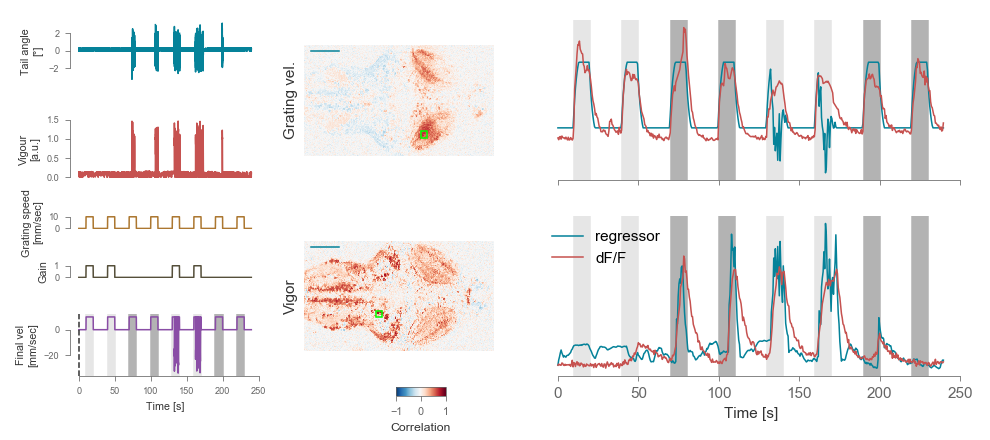

C:\Users\lpetrucco\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
C:\Users\lpetrucco\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [14]:
wnd = 5  # Window for calculating the fluorescence trace around maximum
bar_100um_len = int(100 / (scope_config["um_px"]*scope_config["binning"]))  # size in pixels of a 100 um scalebar
fig = plt.figure(figsize=(9,4))
cols = sns.color_palette()

figcols = 8
figrows = 8


# Regressors panel:
for j, (coef_map, regressor, title) in enumerate(zip([vel_corr_map, vig_corr_map], 
                                              [vel_regressor, vig_regressor],
                                              ["Grating vel.", "Vigor"])):
    max_pos = np.unravel_index(np.argmax(coef_map), coef_map.shape)  # find maximum
    reg_trace = interp_stack[:, max_pos[0]-wnd:max_pos[0]+wnd, 
                             max_pos[1]-wnd:max_pos[1]+wnd].mean((1,2))  # calculate mean fluorescence around maximum

    # Plot map and a square around the maximum:
    plt.subplot2grid((figcols, figrows), (j*4, 2), colspan=2, rowspan=4)
    plt.ylabel(title)
    im = plt.imshow(coef_map.T, cmap = "RdBu_r", vmax=1, vmin=-1, interpolation='none')
    rect = Rectangle((max_pos[0]-wnd, max_pos[1]-wnd), wnd*2, wnd*2, fill=False, edgecolor=[0,1,0])
    plt.gca().add_patch(rect)
    plt.plot([10, bar_100um_len+10], [10, 10])
    plt.xticks([])
    plt.yticks([])
    [plt.gca().spines[s].set_color(None) for s in ["left", "bottom"]]

    # Plot regressor and calcium trace:
    plt.subplot2grid((figcols, figrows), (j*4, 4), colspan=4, rowspan=4)
    plt.plot(time_arr, zscore(regressor), label="regressor")
    plt.plot(time_arr, zscore(reg_trace), label="dF/F")
    plt.gca().spines["left"].set_color(None)
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_ticklabels([])
    
    # Plot stimulus rectangles:
    for s, e, g in zip(start_times, end_times, gains):
        if g == 0:
            plt.axvspan(s, e, color = (0.7,)*3)
        else:
            plt.axvspan(s, e, color = (0.9,)*3)
            
sns.despine(left=True, trim=True)
plt.legend()
plt.gca().xaxis.set_ticklabels(np.arange(0, 300, 50))
plt.xlabel("Time [s]")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.4, 0.1, 0.05, 0.02])
cb = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", ticks=[-1, 0,1])
cb.set_label("Correlation", fontsize=8)
cb.ax.tick_params(labelsize=7) 


beh_lab_font = 7

# Behaviour panel
plt.subplot2grid((figcols, figrows), (0, 0), colspan=2, rowspan=2)
plt.plot(tail_log_df["t"], tail_log_df["tail_sum"], c=cols[0])
plt.gca().xaxis.set_visible(False)
plt.gca().tick_params(labelsize=6)
plt.gca().spines["bottom"].set_color(None)
plt.ylabel('Tail angle\n[°]', fontsize=beh_lab_font)

plt.subplot2grid((figcols, figrows), (2, 0), colspan=2,  rowspan=2)
plt.plot(estm_log_df["t"], estm_log_df["vigour"], c=cols[1])
plt.gca().xaxis.set_visible(False)
plt.gca().tick_params(labelsize=6)
plt.gca().spines["bottom"].set_color(None)
plt.ylabel('Vigour\n[a.u.]',  fontsize=beh_lab_font)

plt.subplot2grid((figcols, figrows), (4, 0), colspan=2)
plt.plot(stim_log_df["t"], -stim_log_df["closed loop 1D_base_vel"], c=cols[2])
plt.gca().xaxis.set_visible(False)
plt.gca().tick_params(labelsize=6)
plt.gca().spines["bottom"].set_color(None)
plt.ylabel('Grating speed\n[mm/sec]',  fontsize=beh_lab_font)

plt.subplot2grid((figcols, figrows), (5, 0), colspan=2)
plt.plot(stim_log_df["t"], stim_log_df["closed loop 1D_gain"], c=cols[7])
plt.gca().xaxis.set_visible(False)
plt.gca().tick_params(labelsize=6)
plt.gca().spines["bottom"].set_color(None)
plt.ylabel('Gain',  fontsize=beh_lab_font)

plt.subplot2grid((figcols, figrows), (6, 0), colspan=2,  rowspan=2)
plt.plot(stim_log_df["t"], -stim_log_df["closed loop 1D_vel"],  c=cols[3])
plt.xticks(np.arange(0, 251, 50))
plt.gca().tick_params(labelsize=6)
plt.ylabel('Final vel\n[mm/sec]',  fontsize=beh_lab_font)
plt.xlabel('Time [s]', fontsize=beh_lab_font)

# Add microscope trigger line and stimulus colors
plt.axvline(0, c=(0.2,)*3,linestyle="dashed")
for s, e, g in zip(start_times, end_times, gains):
    if g == 0:
        plt.axvspan(s, e, color = (0.7,)*3)
    else:
        plt.axvspan(s, e, color = (0.9,)*3)

sns.despine(trim=True)

plt.tight_layout()

In [27]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['svg.fonttype'] = 'none'

fig.savefig("imaging.svg", format="svg")